# Preprocessing
### Imports

New Python versions sometimes require some extra installations found in the code below

In [2]:
!pip install standard-sunau standard-aifc


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [1]:
#Set Dir 
import sys, os
sys.path.append(os.path.abspath('..'))

# Torch
import torch
from torch.utils.data import DataLoader, Dataset
# Utils
import numpy as np
from numpy import ndarray
import logging
# Base Scripts
from Libraries.Utils import *
from Conf import conf


c:\Users\finia\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Config

In [5]:
remote_kernel: bool = False
training_data_name: str = "training_mel_24"
n_samples: int = 10000
logging_level: int = LIGHT_DEBUG
logging.basicConfig(level=logging_level, format='%(asctime)s - %(levelname)s - %(message)s')
logger: logging.Logger = logging.getLogger(__name__)
filenames = get_filenames_from_folder(path_to_remote_path(conf["paths"].data_path, remote_kernel), "wav")

2025-06-14 11:09:47,498 - LIGHT_DEBUG - Got filenames ['Am Bach 2024.wav', 'Cutting Mixes mix.wav', 'DA2407_ADO.wav'] from ../Data


### Processing

In [3]:
data: list = []
remaining_samples: int = n_samples
for i in range(len(filenames)):
    file = load_audio_file(os.path.join(path_to_remote_path(conf["paths"].data_path, remote_kernel), filenames[i]), 24000, True)
    file = split_audiofile(file, 5.4614, 24000, 0)[:, :2**17]
    file = audio_splits_to_mel_spectrograms(file, 1023, 256, 24000, True, 30, 96)
    data.append(file)
    if file.shape[0] < remaining_samples:
        remaining_samples -= file.shape[0]
    else: break

data: ndarray = np.vstack(data)
data = normalize_filewise(data, -1, 1)
#data = dimension_for_VAE(data)[:n_samples]
logger.info(f"Processed data of shape: {data.shape}")

2025-06-14 11:07:55,951 - LIGHT_DEBUG - Loaded audio form ../Data\Am Bach 2024.wav of dimensions: (181426221,), sr: 24000
2025-06-14 11:07:56,395 - LIGHT_DEBUG - Split audio to: (1385, 131073)
2025-06-14 11:07:56,480 - LIGHT_DEBUG - Started Mel-Spec on splits


2025-06-14 11:08:18,000 - LIGHT_DEBUG - Processed Splits: 1380


2025-06-14 11:08:18,912 - LIGHT_DEBUG - Created Mel-spectrograms of splits: (1385, 96, 512)
2025-06-14 11:08:30,502 - LIGHT_DEBUG - Loaded audio form ../Data\Cutting Mixes mix.wav of dimensions: (144487981,), sr: 24000
2025-06-14 11:08:30,765 - LIGHT_DEBUG - Split audio to: (1103, 131073)
2025-06-14 11:08:30,823 - LIGHT_DEBUG - Started Mel-Spec on splits


2025-06-14 11:08:44,000 - LIGHT_DEBUG - Processed Splits: 1100


2025-06-14 11:08:44,286 - LIGHT_DEBUG - Created Mel-spectrograms of splits: (1103, 96, 512)
2025-06-14 11:09:01,461 - LIGHT_DEBUG - Loaded audio form ../Data\DA2407_ADO.wav of dimensions: (184516608,), sr: 24000
2025-06-14 11:09:01,875 - LIGHT_DEBUG - Split audio to: (1408, 131073)
2025-06-14 11:09:01,963 - LIGHT_DEBUG - Started Mel-Spec on splits


2025-06-14 11:09:23,000 - LIGHT_DEBUG - Processed Splits: 1400


2025-06-14 11:09:24,371 - LIGHT_DEBUG - Created Mel-spectrograms of splits: (1408, 96, 512)
2025-06-14 11:09:25,775 - LIGHT_DEBUG - Normalized to range: [-1,1]
2025-06-14 11:09:25,869 - INFO - Processed data of shape: (3896, 96, 512)


### Saving

In [6]:
save_training_data(data, f"{path_to_remote_path(conf["paths"].data_path, remote_kernel)}/{training_data_name}.npy")

2025-06-14 11:09:55,855 - LIGHT_DEBUG - Saved ndarray to:../Data/training_mel_24.npy


### Test Blocks

In [7]:
print(np.min(data), np.max(data))

-1.0 1.0


In [10]:
file = load_audio_file(os.path.join(path_to_remote_path(conf["paths"].data_path, remote_kernel), filenames[0]), 24000, True)
file = split_audiofile(file, 5.4614, 24000, 0)[:, :2**17]


2025-06-14 11:18:26,488 - LIGHT_DEBUG - Loaded audio form ../Data\Am Bach 2024.wav of dimensions: (181426221,), sr: 24000
2025-06-14 11:18:27,123 - LIGHT_DEBUG - Split audio to: (1385, 131073)


In [18]:
import torch

from vocos import Vocos

mel = torch.tensor(normalize(audio_to_mel_spectrogram(file[70], 1023, 256, 24000, True, min_freq=30, n_mels=100))[:, :256]).unsqueeze(0)

vocos = Vocos.from_pretrained("charactr/vocos-mel-24khz")

audio = vocos.decode(mel)

2025-06-14 11:21:29,659 - LIGHT_DEBUG - Started Mel-Spec
2025-06-14 11:21:29,680 - LIGHT_DEBUG - Created mel-spectrogram: (100, 512)
2025-06-14 11:21:29,681 - LIGHT_DEBUG - Normalized to range: [-1,1]


In [22]:
save_audio_file(librosa.feature.inverse.mel_to_audio(normalize(audio_to_mel_spectrogram(file[70], 1023, 256, 24000, True, min_freq=30, n_mels=100)), sr=24000,n_fft=1023, hop_length=256), "gl_reconstructed.wav", 24000)

2025-06-14 11:35:18,504 - LIGHT_DEBUG - Started Mel-Spec
2025-06-14 11:35:18,768 - LIGHT_DEBUG - Created mel-spectrogram: (100, 512)
2025-06-14 11:35:18,770 - LIGHT_DEBUG - Normalized to range: [-1,1]
2025-06-14 11:35:22,895 - LIGHT_DEBUG - Normalized to range: [-0.99999,0.99999]
2025-06-14 11:35:22,905 - LIGHT_DEBUG - Saved file to:gl_reconstructed.wav


2025-06-14 11:18:39,020 - LIGHT_DEBUG - Started Mel-Spec
2025-06-14 11:18:39,046 - LIGHT_DEBUG - Created mel-spectrogram: (100, 512)
2025-06-14 11:18:39,048 - LIGHT_DEBUG - Normalized to range: [-1,1]


(100, 512)


2025-06-14 11:18:39,432 - LIGHT_DEBUG - Started Mel-Spec
2025-06-14 11:18:39,463 - LIGHT_DEBUG - Created mel-spectrogram: (96, 512)
2025-06-14 11:18:39,465 - LIGHT_DEBUG - Normalized to range: [-1,1]


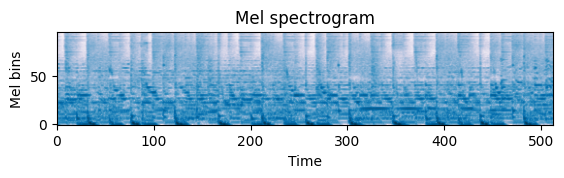

'\nspec = audio_to_mel_spectrogram(file[70], 2048, 256, 32000, True, min_freq=30, n_mels=128)\nspec = normalize(spec, -1, 1)\nplt.imshow(spec, cmap = "PuRd", origin="lower")\n'

In [13]:
print(normalize(audio_to_mel_spectrogram(file[70], 1023, 256, 24000, True, min_freq=30, n_mels=100)).shape)
plt.title("Mel spectrogram")
plt.xlabel("Time")
plt.xlim(0, 512)
plt.ylabel("Mel bins")
plt.imshow(normalize(audio_to_mel_spectrogram(file[70], 1023, 256, 32000, True, min_freq=30, n_mels=96)), origin="lower", cmap="PuBu")
plt.show()
"""
spec = audio_to_mel_spectrogram(file[70], 2048, 256, 32000, True, min_freq=30, n_mels=128)
spec = normalize(spec, -1, 1)
plt.imshow(spec, cmap = "PuRd", origin="lower")
"""
#save_audio_file(spectrogram_to_audio(spec, 480, 288, conf["audio"].sample_rate), "../Results/low_res.wav", sample_rate=conf["audio"].sample_rate)